# Co-editors

This page focuses on co-editorship, especially of edited volumes, but including also editions, in the *Bibliographie*.   

In [2]:
# === Imports === 

import re 
import seaborn as sns
from matplotlib import pyplot as plt
from os.path import join, abspath, normpath, realpath
import os
from lxml import etree
from io import StringIO, BytesIO
from collections import Counter
import pandas as pd
import netgraph
import numpy as np
from IPython.display import HTML, display   
import networkx as nx
from pyvis.network import Network 
import matplotlib.pyplot as plt


# === Namespaces === 

namespaces = {
    "foaf" : "http://xmlns.com/foaf/0.1/",
    "bib" : "http://purl.org/net/biblio#",
    "dc" : "http://purl.org/dc/elements/1.1/",
    "z" : "http://www.zotero.org/namespaces/export#",
    "rdf" : "http://www.w3.org/1999/02/22-rdf-syntax-ns#"
    }


# === Files and parameters === 

bibdatafile = join("data", "BIB18_Zotero-RDF_2024-01-02.rdf") 
#bibdatafile = join(wdir, "data", "BIB18_Zotero-RDF_TEST.rdf") 
#graphviz_file = join(wdir, "figures", "collaboration_coeditors-network.svg") 


# === Load the dataset === 

def read_xml(bibdatafile): 
    bibdata = etree.parse(bibdatafile)
    return bibdata

bibdata = read_xml(bibdatafile)


## Collecting all publications that have editors

For the time being, only books (including editions) and book sections are considered. Multiple entries of the same edited volume are taken into account only once. This avoids an undue inflation of the number of cases of co-editorship in cases where multiple chapters from the same edited volume are present in the database. 

Note that there is a peculiar practice in the French publishing landscape, that of edited volumes that have been edited ('dirigé') by one or several people in collaboration with one or several other people ('avec la collaboration de'). The role of these latter collaborators, whether as scientific co-editors with a slightly lesser degree of responsibility than the main editor, or rather as editorial assistants, is not always clear. In addition, they are sometimes named on the front page, sometimes only in the front matter. Finally, this information is not represented clearly in the dataset at this point, so some caution is advised.  

In [3]:
def get_editordata(bibdata): 
    """
    Collects data on the titles and editors of all collected volumes for which the dataset includes book sections (like chapters).
    Simplifies the data to just unique titles of collected volumes with their editors.
    """
    # Find all instances of book chapters or book sections
    xpath = "//bib:BookSection"
    sections = bibdata.xpath(xpath, namespaces=namespaces)
    print("There are " + str(len(sections)) +  " instances of element 'BookSection'.")

    # Also, find all instances of books mentioned as a whole and that have editors. 
    xpath = "/rdf:RDF/bib:Book"
    books = bibdata.xpath(xpath, namespaces=namespaces)
    print("There are " + str(len(books)) +  " instances of element 'book'.")
    sections.extend(books)
    print("Overall, there are", len(sections), "publications included at this point.")

    # For each section (and each book), get the editor(s) and booktitle
    editordata = {}
    counter = 0
    for item in sections[:]: 
        counter +=1
        # Get the editors' last names
        xpath = ".//bib:editors//foaf:surname//text()"
        editors_last = item.xpath(xpath, namespaces=namespaces)
        editors_last = [editor for editor in editors_last if "lacollaborationde" not in editor]
        # Get the editors' first names
        xpath = ".//bib:editors//foaf:givenName//text()"
        editors_first = item.xpath(xpath, namespaces=namespaces)
        editors_first = [editor for editor in editors_first if "avec" not in editor]
        # Combine the names in a concise manner
        editors = []
        for last, first in zip(editors_last, editors_first):
            full = last + "_" + first
            editors.append(full)
        # Get the book titles
        xpath = ".//bib:Book/dc:title//text()"
        try: 
            booktitle = item.xpath(xpath, namespaces=namespaces)[0]
        except: 
            booktitle = "missing title number " + str(counter)
            #print(booktitle) # Only happens less than 10 times, it seems. 
        # Collect each booktitle only once; only last occurrence is kept (!)
        if len(editors) > 0: 
            editordata[booktitle] = editors
    # Check results 
    #print("All of the book sections mentioned above correspond to (only)", len(editordata), "different titles of edited volumes.")
    #ratio = np.round(np.divide(len(sections), len(editordata)),2)
    #print("This means that, on average, an edited volume is mentioned", ratio, "times, each mention corresponding to one section of the volume being mentioned.")

    #for title,editors in editordata.items(): 
    #    print(editors,title)
    return editordata
editordata = get_editordata(bibdata)

There are 14421 instances of element 'BookSection'.
There are 23059 instances of element 'book'.
Overall, there are 37480 publications included at this point.


Note that many of the books don't have editors, because they are monographs. Also, many book sections correspond to different chapters from the same edited volume. Whenever that is the case, the books without editor are discarded and each edited volume is only considered once, in the next step. The total number of publications considered for the co-editor analysis is therefore substantially lower. 


## Prevalence of co-editor numbers 

Based on the data on book titles that have one or several editors, we can now investigate the prevalence of the different numbers of editors books typically have. The following table shows this data. 

In [4]:
def get_coeditor_numbers(editordata): 
    """
    Based on the editordata, establish the number of times each number of co-editors appears, 
    as well as the corresponding percentages for each number of co-editors. 
    """
    coeditors = Counter([len(item) for item in editordata.values()])
    coeditors = pd.DataFrame(pd.Series(coeditors, name="count"))
    #coeditors.drop(0, axis=0, inplace=True)

    coeditors["percentage"] = np.round(np.multiply(np.divide(coeditors["count"], np.sum(coeditors["count"])),100),1)
    # Prettify the DataFrame
    coeditors["number"] = coeditors.index
    coeditors = coeditors.sort_values(by="number")
    coeditors = coeditors[['number', 'count', 'percentage']]
    display(HTML(coeditors.to_html(index=False)))
    return coeditors
coeditors = get_coeditor_numbers(editordata)

number,count,percentage
1,2730,39.8
2,2847,41.5
3,966,14.1
4,259,3.8
5,49,0.7
6,5,0.1
10,1,0.0


The following visualization shows counts and percentages for different numbers of co-editors.

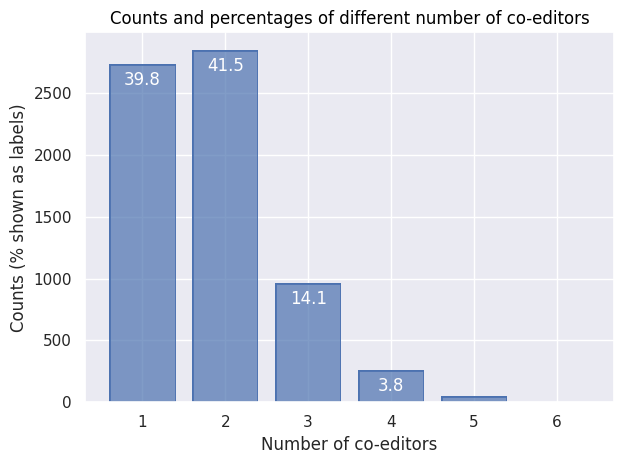

In [5]:
def visualize_coeditor_numbers(coeditors): 
    """
    Create a simple bar plot that shows 
    the percentage of each number of co-editors in the dataset.
    """

    coeditors = coeditors.iloc[:-1,:]
    import seaborn.objects as so
    (
        so.Plot(data=coeditors, x="number", y="count", text="percentage")
        .add(so.Bar())
        .add(so.Text(color="w", valign="top", offset=5))
        .scale(x=so.Continuous().tick(every=1))
        .label(
            x="Number of co-editors",
            y="Counts (% shown as labels)",
            title = "Counts and percentages of different number of co-editors")
        .save("figures/coeditor-percentages.svg", dpi=300)
        .show()
    )
visualize_coeditor_numbers(coeditors)

Compared with the data on co-authorship (of books, articles and chapters), the figure above shows that co-editorship works quite differently. Indeed, when looking at editorship (of edited volumes or editions), joint editorship with two editors is the most common case (with almost 42% of the cases). Single editorship, however, is only slighly less widespread (at 39%). Triple co-editorship is also not uncommon, though clearly at a much lower level (at around 14%). 

It could be interesting to distinguish between editorship of edited volumes on the one hand, and textual editions, on the other hand. This is future work, because the dataset does not distinguish these two publication types at the moment. 

## Coeditor pairs

This section looks at which people have frequently collaborated as editors of edited volumes and/or editions. The table below shows the 10 most active pairs of editors.


In [7]:
import warnings
import pandas as pd
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)


def get_recurring_coeditors(editordata, topn): 
    """
    Which people have frequently collaborated as editors? 
    This is based on the data collected above (editors of unique titles). 
    """

    # Define filenames for output. 
    coeditorcounts_top_file = join("results", "coeditor-counts_top.csv")
    coeditorcounts_full_file = join("results", "coeditor-counts_full.csv")

    # Get editor names from editordata. 
    coeditors = editordata.values()
    print("Overall,", len(coeditors), "publications with editors are considered here.")
    coeditor_names = [item for sublist in coeditors for item in sublist]
    print("Also, there are", len(set(coeditor_names)) , "different editors represented in the data.")

    # Establish the count of each collaboration between editors
    import itertools 
    all_coeditor_combinations = []
    for item in coeditors: 
        coeditor_combinations = list(itertools.combinations(item, 2))
        coeditor_combinations = [tuple(sorted(item)) for item in coeditor_combinations]
        for coedcomb in coeditor_combinations: 
            all_coeditor_combinations.append(coedcomb)
    ccc = dict(Counter(all_coeditor_combinations)) # ccc = coeditor_combinations_count

    # Transform to a DataFrame
    ccc = pd.DataFrame.from_dict(ccc, orient="index", columns=["count"])
    ccc = ccc.reset_index()
    ccc_split = pd.DataFrame(ccc["index"].tolist())
    ccc_merged = ccc_split.merge(ccc, left_index=True, right_index=True)
    ccc = ccc_merged.drop(["index"], axis=1)
    ccc = ccc.rename({0 : "coeditor1", 1 : "coeditor2"}, axis=1)
    ccc = ccc.sort_values(by="count", ascending=False)
    #print(ccc.head())
    #print(ccc.shape, "shape of dataframe")
    with open(join(coeditorcounts_full_file), "w", encoding="utf8") as outfile: 
        ccc.to_csv(outfile, sep=";")

    # Filter the DataFrame to make it manageable for visualization
    # Determine the top N most frequent co-editors
    coeditors_top = list(set(list(ccc.head(topn).loc[:,"coeditor1"]) +\
        list(ccc.head(topn).loc[:,"coeditor2"])))
    #print(coeditors_top)
    print("Among all editors, " + str(len(coeditors_top)) + " have been selected as the most active co-editors.")
    print("In the following analysis, all editors they have collaborated with, however, are included.")
    # Filter the DataFrame to include just the collaborations involving at least one of the top co-editors. 
    # The resulting DataFrame will have all collaborations between the top co-editors and their co-editors. 
    ccc_filtered = ccc[(ccc["coeditor1"].isin(coeditors_top)) |\
                       (ccc["coeditor2"].isin(coeditors_top))]
    #print(ccc_filtered.shape, "shape of dataframe of top co-editors and their co-editors.")
    # Simplify the labels 
    #ccc_filtered = ccc_filtered.replace(' .*?]', '',regex=True).astype(str)
    ccc_filtered.loc[:,'coeditor1'] =  [re.sub(r', .*','', str(x)) for x in ccc_filtered.loc[:,'coeditor1']]
    ccc_filtered.loc[:,'coeditor2'] =  [re.sub(r', .*','', str(x)) for x in ccc_filtered.loc[:,'coeditor2']]

    # Display this as a formatted table    
    display(HTML(ccc_filtered.head(10).to_html(index=False)))

    # Save to disk 
    with open(join(coeditorcounts_top_file), "w", encoding="utf8") as outfile: 
        ccc_filtered.to_csv(outfile, sep=";")
    return ccc, ccc_filtered

ccc, ccc_filtered = get_recurring_coeditors(editordata, topn=150)

Overall, 6857 publications with editors are considered here.
Also, there are 7151 different editors represented in the data.
Among all editors, 208 have been selected as the most active co-editors.
In the following analysis, all editors they have collaborated with, however, are included.


coeditor1,coeditor2,count
Herman_Jan,Pelckmans_Paul,24
Hasquin_Hervé,Mortier_Roland,18
Biard_Michel,Leuwers_Hervé,12
Biard_Michel,Bourdin_Philippe,11
Berchtold_Jacques,Porret_Michel,9
Bourdin_Philippe,Leuwers_Hervé,8
Peeters_Kris,Pelckmans_Paul,8
Herman_Jan,Peeters_Kris,8
Didier_Béatrice,Neefs_Jacques,7
Berchtold_Jacques,Martin_Christophe,7


## Co-editor network

Based on the frequency of co-editorships, it is possible to draw a network representation. 

The network visualization shows the editors as nodes, with their weighted degree determining the node size (the more publications they have edited with together with someone else, the larger the node). And it shows the intensity of their collaboration as the edges, with the number of coedited volumes determining the edge thickness (the more publications two editors have collaborated on, the thicker the line between them). The network layout aims to show groups of people who belong to a sub-network of co-editors who, as a group, work together frequently. 

In [8]:
def create_plot(ccc_filtered): 
    """ 
    Plot the co-editor data as a network using pyvis. 
    """
    # Prepare the dataset
    cccf = ccc_filtered
    cccf.rename(columns={"count": "weight"}, inplace=True)
    cccf = cccf[cccf["weight"] > 0] # for filtering, with "0", all items remain

    # Load the data into a NetworkX graph
    net = Network('1600px', '2800px', notebook=True, cdn_resources='in_line')
    G = nx.Graph()
    for line in cccf.iterrows(): 
        #print(line[1][0], end="\n")
        G.add_edge(
            # full names
            line[1][0],
            line[1][1],
            # last names only
            #re.split("_", line[1][0])[0],
            #re.split("_", line[1][1])[0],
            weight=line[1][2],
            title=line[1][2],
            )
    degrees = dict(G.degree)
    degrees.update((x, ((y*50)**0.5)) for x, y in degrees.items())
    nx.set_node_attributes(G, degrees, 'size') 
    print("The network includes a total of", str(nx.number_of_nodes(G)), "editors.")

    # Plot the data using pyvis
    net.from_nx(G)
    net.toggle_physics(True)
    net.show("figures/coeditor-network.html")
create_plot(ccc_filtered)


The network includes a total of 618 editors.
figures/coeditor-network.html


This data can be visualized as a network. Click on the following image for an interactive network plot. 

When interpreting the data, please note that (a) the number of key editors selected and (b) the minimum number of collaborations are important parameters of this network. If all editors are included, and/or single collaborations are retained, the network becomes unwieldy (and the graph loads slowly). However, the number of sub-networks, and their degree of connectivity among each other, varies strongly when these parameters are modified. 

The current network uses a total of 618 editors (all 208 editors included in the top-150 editor pairs and all editors connected to them), and does not filter out any rarer collaborations. That's only around 10% of the total number of editors in the dataset, but at this setting, the network remains readable and already loads quite slowly. 

[![coeditor network](figures/coeditor-network_dummy.png)](figures/coeditor-network.html) 

The visualization shows, like the tabular display, that Herman and Pelckmans (with 24 co-edited volumes the collaborated on!) and Hasquins and Mortier (with 18 edited volumes) are the most intense collaborators in terms of co-editorship. 

More interestingly, however, the network visualisation shows that there are multiple, independent co-editor networks. Some are star-shaped and dominated by one editor working with many different co-editors (like the sub-networks around Grande or Seth). A few are dominated by a binary relationship (like the ones around Neefs and Didier, Hersant et Ramond, Plagnol-Diéval and Cook, or the one made up of Mortier and Hasquin). Others involve a triangular relationship (like the ones involving Herman, Pelckmans, Peeters; or the one with Bourdin, Biard, Leuwers). The unconnected sub-network formed by five co-editors (Bouvier, Brunat, Kohlhauer, Barthélémy, Clerc) is an interesting case of a small but tight and independent co-editor network. 

In addition, many of these sub-networks are loosely connected between each other, while others are entirely disconnected from the main network. And some co-editors serve as connections between several sub-networks. This depends the most, however, at least in my experience, on the number of editors considered and would be best analyzed statistically on the entire network by way of determining nodes with a high betweenness centrality (rather than degree centrality). 

## An additional look at the graph data

Based on the data modeled as a graph, we can not only visualize it, but also extract some additional information. This is done here for the entire dataset, not just the top coeditors as in the visualization. 


This essentially shows that, while some _editor pairs_ have worked together particularly frequently (think Herman and Pelckman or Hasquin and Mortier above), they are not necessarily the ones who have engaged in the most co-editorships overall. Lüsebrink and Porret are clearly the people who have engaged in the most co-editor relationships (i.e., cumulated number of co-editors involved in all volumes they co-edited).   

We can also check, as mentioned above, for betweenness centrality of the editors, in order to identify those editors (in the entire graph) that tend to connect otherwise weakly-connected sub-networks. 

In [9]:
def calculate_measures(ccc): 

    # Prepare the dataset
    ccc.rename(columns={"count": "weight"}, inplace=True)
    ccc = ccc[ccc["weight"] > 0] # for filtering (0 is slow but complete)

    # Load the data into a NetworkX graph
    G = nx.Graph()
    for line in ccc.iterrows(): 
        G.add_edge(
            line[1][0],
            line[1][1],
            weight=line[1][2],
            )
    print("Number of editors included in this Graph: " + str(nx.number_of_nodes(G)) + ".")

    # Get the degrees
    dg = dict(G.degree)

    # Get the betweenness centralities
    # See: https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.betweenness_centrality.html
    bc = nx.betweenness_centrality(
        G,
        k=None,
        normalized=True,
        weight=None,
        endpoints=False,
        seed=None
        )

    # Get eigenvector centrality
    ec = nx.eigenvector_centrality(
        G,
        max_iter=100,
        tol=1e-03
        )
    
    # Merge results into a dataframe
    dg = pd.DataFrame.from_dict(dg, orient="index", columns=["degree"])
    dg["coeditor"] = dg.index
    bc = pd.DataFrame.from_dict(bc, orient="index", columns=["betweenness"])
    bc["coeditor"] = bc.index
    ec = pd.DataFrame.from_dict(ec, orient="index", columns=["eigenvector"])
    ec["coeditor"] = ec.index
    #measures = dg.merge(ec, how="inner", on="coeditor")
    measures = dg.merge(bc, on='coeditor').merge(ec,on='coeditor')
    measures = measures[["coeditor", "degree", "betweenness", "eigenvector"]]

    return measures
measures = calculate_measures(ccc)

Number of editors included in this Graph: 5857.


Now we can look at the various graph measures calculated above on the entire network of editors. 

First, the editors with the highes value for degree (number of connections). This describes the total number of co-editorships a given person has engaged in. 

In [10]:
def show_degree(measures): 
    measures.sort_values(by="degree", ascending=False, inplace=True)
    degree = measures.drop(["betweenness", "eigenvector"], axis=1, inplace=False)
    display(HTML(degree.head(15).to_html(index=False)))
show_degree(measures)


coeditor,degree
Lüsebrink_Hans-Jürgen,23
Porret_Michel,22
Delon_Michel,18
Bourdin_Philippe,18
Berchtold_Jacques,18
Seth_Catriona,18
Paganini_Gianni,17
Leuwers_Hervé,17
Bertrand_Gilles,15
Moureau_François,15


Similarly, we can look at the betweenness centrality. This is a measure that describes how much an editor acts as a connection between various subnetworks. "Betweenness centrality quantifies the number of times a node acts as a bridge along the shortest path between two other nodes", as per Wikipedia.  

In [11]:
def show_betweenness(measures): 
    measures.sort_values(by="betweenness", ascending=False, inplace=True)
    betweenness = measures.drop(["eigenvector"], axis=1, inplace=False)
    display(HTML(betweenness.head(15).to_html(index=False)))
show_betweenness(measures)

coeditor,degree,betweenness
Porret_Michel,22,0.010365
Berchtold_Jacques,18,0.009650
Seth_Catriona,18,0.009246
Bernier_Marc André,11,0.008750
Delon_Michel,18,0.006522
Moureau_François,15,0.005221
Volpilhac-Auger_Catherine,11,0.004951
Lotterie_Florence,14,0.004941
Hersant_Marc,11,0.004284
Plagnol-Diéval_Marie-Emmanuelle,11,0.004219


Finally, we can look at eigenvector centrality, a measure of influence in a network. 

In [12]:
def show_eigenvector(measures): 
    measures.sort_values(by="eigenvector", ascending=False, inplace=True)
    eigenvector = measures.drop(["betweenness"], axis=1, inplace=False)
    display(HTML(eigenvector.head(15).to_html(index=False)))
show_eigenvector(measures)

coeditor,degree,eigenvector
Hébert_Pierre,13,0.257840
Luneau_Marie-Pier,12,0.252006
Michon_Jacques,10,0.250391
Brisson_Frédéric,9,0.243162
Godbout_Patricia,9,0.243162
Mylène Fréchette_Fanie St-Laurent,9,0.243162
Vincent_Josée,9,0.243162
Drouin_de Sophie,9,0.243162
Marcel Lajeunesse_Éric Leroux,9,0.243162
Pouliot_Suzanne,9,0.243162


The eigenvector centrality is interesting because it surfaces editors who do not necessarily have very high degree or betweenness centrality scores, like Pierre Hébert. It remains to be seen what exactly this says about them!